In [2]:
# Phân cụm khách hàng bằng K-Means + đánh giá cụm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [3]:
df = pd.read_csv("data/ecommerce_cleaned.csv")
df.head()

,User_ID,Product_ID,Category,Price (Rs.),Discount (%),Final_Price(Rs.),Payment_Method,Purchase_Date,TotalPrice,Month,Year
0,337c166f,f414122f-e,Sports,36.53,15,31.05,Net Banking,2024-12-11,31.0505,12.0,2024.0
1,d38a19bf,fde50f9c-5,Clothing,232.79,20,186.23,Net Banking,2024-09-02,186.2320,9.0,2024.0
2,d7f5f0b0,0d96fc90-3,Sports,317.02,25,237.76,Credit Card,2024-01-09,237.7650,1.0,2024.0
3,395d4994,964fc44b-d,Toys,173.19,25,129.89,Upi,2024-01-04,129.8925,1.0,2024.0
4,a83c145c,d70e2fc6-e,Beauty,244.80,20,195.84,Net Banking,NaN,195.8400,NaN,NaN


In [4]:
#Tổng hợp dữ liệu theo mỗi khách hàng: Tổng chi tiêu, Số lần mua hàng, giá trị trung bình mỗi đơn, số danh mục sản phẩm khác nhau đã mua
customer_df = df.groupby("User_ID").agg({
    "Final_Price(Rs.)": ["sum", "mean"],
    "Product_ID": "count",
    "Category": "nunique"
})

customer_df.columns = ["Total_Spending", "Avg_Order_Value", "Total_Orders", "Unique_Categories"]
customer_df = customer_df.reset_index()
customer_df.head()

,User_ID,Total_Spending,Avg_Order_Value,Total_Orders,Unique_Categories
0,001ae40d,345.93,345.93,1,1
1,00209791,10.32,10.32,1,1
2,0021e458,123.51,123.51,1,1
3,00333c7a,8.65,8.65,1,1
4,00390cf5,96.32,96.32,1,1


In [5]:
features = ["Total_Spending", "Avg_Order_Value", "Total_Orders", "Unique_Categories"]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_df[features])


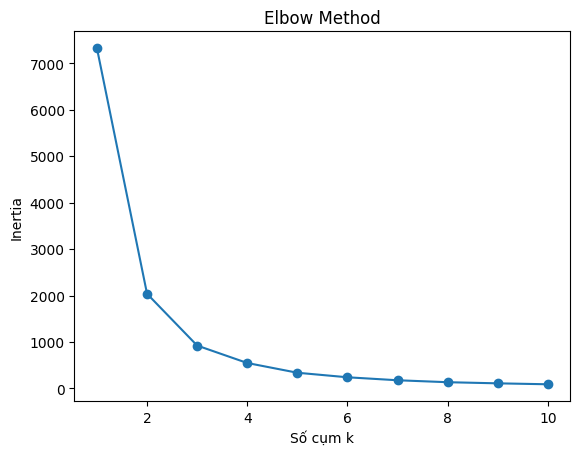

In [6]:
#Xác định số cụm tối ưu (k) bằng Elbow Method
inertia = []

for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Số cụm k")
plt.ylabel("Inertia")
plt.show()


In [7]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
customer_df["Cluster"] = kmeans.fit_predict(scaled_data)


In [8]:
#Giảm chiều bằng PCA để trực quan hóa
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

customer_df["PCA1"] = pca_result[:, 0]
customer_df["PCA2"] = pca_result[:, 1]


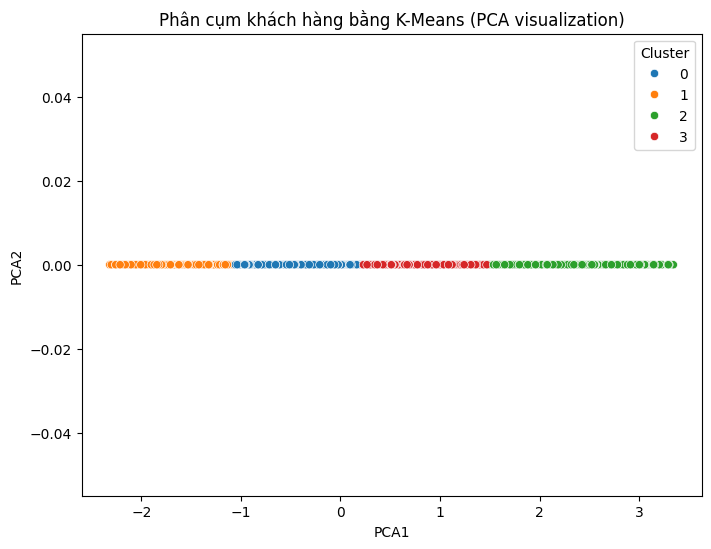

In [9]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=customer_df, x="PCA1", y="PCA2", hue="Cluster", palette="tab10")
plt.title("Phân cụm khách hàng bằng K-Means (PCA visualization)")
plt.show()


In [10]:
cluster_summary = customer_df.groupby("Cluster")[features].mean()
cluster_summary

,Total_Spending,Avg_Order_Value,Total_Orders,Unique_Categories
Cluster,,,,
0,169.420348,169.420348,1.0,1.0
1,60.091921,60.091921,1.0,1.0
2,392.503669,392.503669,1.0,1.0
3,278.272639,278.272639,1.0,1.0


In [11]:
from pathlib import Path
import pandas as pd

# 1. Định nghĩa đường dẫn thư mục
output_path = Path("result")

# 2. Tạo thư mục nếu nó chưa tồn tại
# parents=True cho phép tạo các thư mục cha nếu chúng cũng không tồn tại.
# exist_ok=True cho phép hàm chạy mà không báo lỗi nếu thư mục đã tồn tại.
output_path.mkdir(parents=True, exist_ok=True)

# 3. Lưu DataFrame vào đường dẫn tệp đầy đủ
file_path = output_path / "customer_clusters.csv"
customer_df.to_csv(file_path, index=False)

print(f"Đã lưu tệp thành công tại: {file_path}")


Đã lưu tệp thành công tại: result\customer_clusters.csv


In [15]:
import os
import pickle

# Tạo đường dẫn tuyệt đối đến thư mục models
model_dir = "../Web_app/models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "kmeans_model.pkl")

# Lưu mô hình
with open(model_path, "wb") as f:
    pickle.dump(kmeans, f)

print("Đã lưu mô hình vào:", model_path)



Đã lưu mô hình vào: ../Web_app/models\kmeans_model.pkl


In [16]:
import pickle

with open("../Web_app/models/kmeans_model.pkl", "rb") as f:
    model_loaded = pickle.load(f)

print(model_loaded)
print(type(model_loaded))


KMeans(n_clusters=4, random_state=42)
<class 'sklearn.cluster._kmeans.KMeans'>
